✅ All packages installed successfully!

📊 Loading Dataset...
Using NSL-KDD dataset (downloading from GitHub)
✅ Training data shape: (125973, 43)
✅ Testing data shape: (22544, 43)

📋 Dataset columns: 43 features

🎯 Attack types distribution:
label
normal         67343
neptune        41214
satan           3633
ipsweep         3599
portsweep       2931
smurf           2646
nmap            1493
back             956
teardrop         892
warezclient      890
Name: count, dtype: int64


🔧 Starting Data Preprocessing...
✅ Data preprocessed successfully!

📊 Attack Categories Distribution:
attack_category
normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: count, dtype: int64


⚙️ Feature Engineering...
✅ Features prepared: 41 features
✅ Training samples: 125973
✅ Testing samples: 22544


📏 Scaling Features...
✅ Features scaled successfully!


🔍 SIGNATURE-BASED DETECTION LAYER
📊 Signature-Based Detection Results:
   Total connections analyzed: 1000
   Threats de

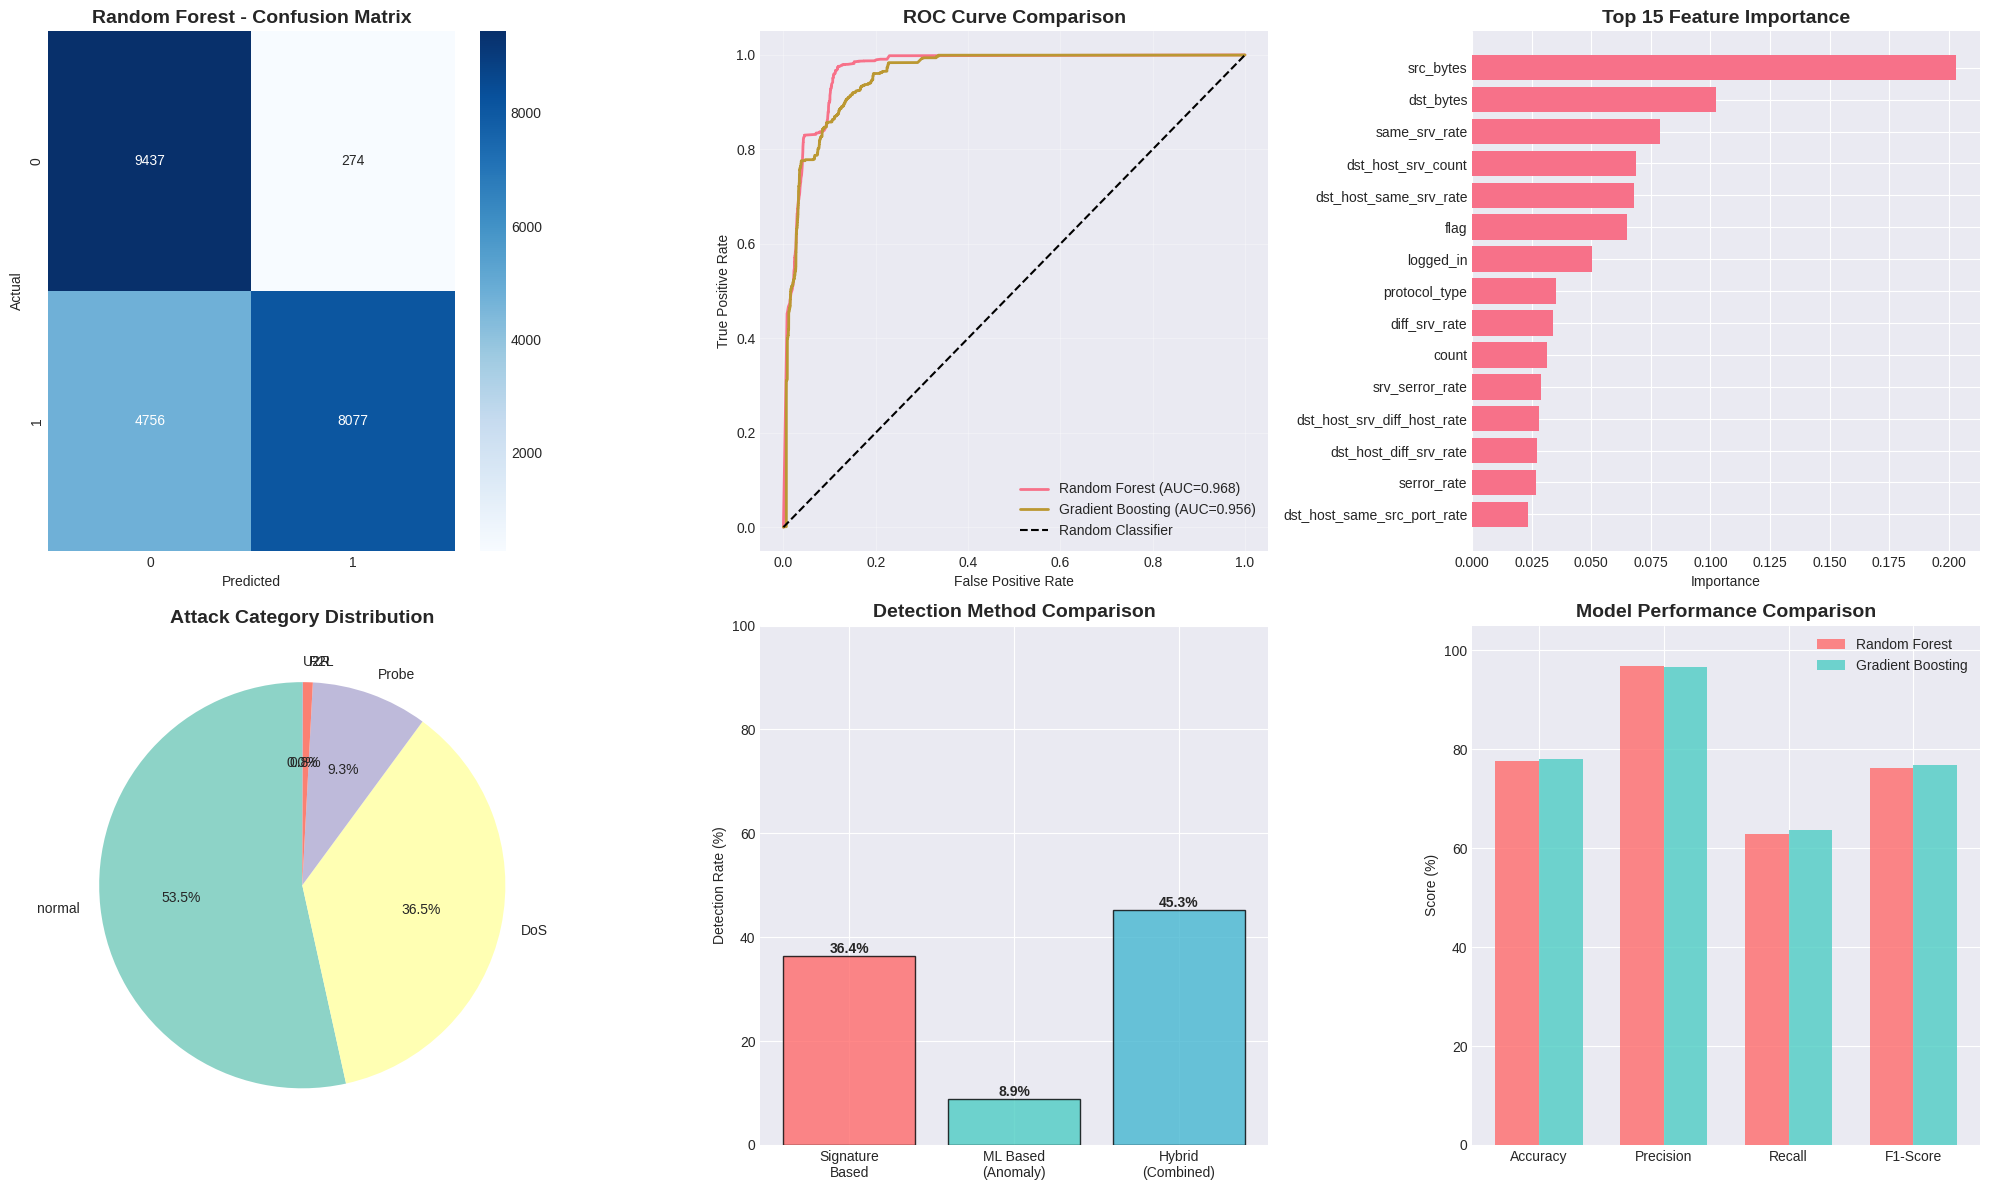



🎯 HYBRID IDS - FINAL EVALUATION REPORT

📊 SYSTEM PERFORMANCE SUMMARY
------------------------------------------------------------
Dataset: NSL-KDD
Total Training Samples: 125,973
Total Testing Samples: 22,544
Number of Features: 41

🌲 RANDOM FOREST CLASSIFIER:
   Accuracy:  77.69%
   Precision: 96.72%
   Recall:    62.94%
   F1-Score:  76.26%
   ROC-AUC:   0.9675

🚀 GRADIENT BOOSTING CLASSIFIER:
   Accuracy:  78.08%
   Precision: 96.59%
   Recall:    63.74%
   F1-Score:  76.80%
   ROC-AUC:   0.9559

🔗 HYBRID DETECTION RESULTS:
   Total Connections Analyzed: 1,000
   Threats Detected (Signature): 364
   Threats Detected (ML): 89
   Total Threats Detected: 453
   Overall Detection Rate: 45.30%

✅ HYBRID IDS IMPLEMENTATION COMPLETE!

💾 Models saved successfully!
   - rf_model.pkl
   - gb_model.pkl
   - scaler.pkl


In [1]:
# ========================================
# HYBRID INTRUSION DETECTION SYSTEM (IDS)
# Complete Google Colab Implementation
# ========================================

# ====================
# SECTION 1: INSTALLATION & IMPORTS
# ====================

# Install required packages
!pip install scikit-learn pandas numpy matplotlib seaborn imbalanced-learn joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                              accuracy_score, precision_score, recall_score,
                              f1_score, roc_auc_score, roc_curve)
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

print("✅ All packages installed successfully!")

# ====================
# SECTION 2: LOAD DATASET
# ====================

print("\n📊 Loading Dataset...")
print("Using NSL-KDD dataset (downloading from GitHub)")

# Download NSL-KDD dataset
!wget -q https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.txt
!wget -q https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest%2B.txt

# Column names for NSL-KDD dataset
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in',
    'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
    'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
    'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'difficulty'
]

# Load training and testing data
train_data = pd.read_csv('KDDTrain+.txt', names=columns, header=None)
test_data = pd.read_csv('KDDTest+.txt', names=columns, header=None)

print(f"✅ Training data shape: {train_data.shape}")
print(f"✅ Testing data shape: {test_data.shape}")
print(f"\n📋 Dataset columns: {len(columns)} features")
print(f"\n🎯 Attack types distribution:")
print(train_data['label'].value_counts().head(10))

# ====================
# SECTION 3: DATA PREPROCESSING
# ====================

print("\n\n🔧 Starting Data Preprocessing...")

def preprocess_data(data):
    """Preprocess network traffic data"""
    # Remove difficulty column
    data = data.drop(['difficulty'], axis=1, errors='ignore')

    # Binary classification: Normal vs Attack
    data['attack_type'] = data['label'].apply(lambda x: 'normal' if x == 'normal' else 'attack')

    # Create detailed attack categories
    dos_attacks = ['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop', 'apache2', 'udpstorm', 'processtable', 'mailbomb']
    probe_attacks = ['ipsweep', 'nmap', 'portsweep', 'satan', 'mscan', 'saint']
    r2l_attacks = ['ftp_write', 'guess_passwd', 'imap', 'multihop', 'phf', 'spy', 'warezclient', 'warezmaster', 'sendmail', 'named', 'snmpgetattack', 'snmpguess', 'xlock', 'xsnoop', 'worm']
    u2r_attacks = ['buffer_overflow', 'loadmodule', 'perl', 'rootkit', 'httptunnel', 'ps', 'sqlattack', 'xterm']

    def categorize_attack(label):
        if label == 'normal':
            return 'normal'
        elif label in dos_attacks:
            return 'DoS'
        elif label in probe_attacks:
            return 'Probe'
        elif label in r2l_attacks:
            return 'R2L'
        elif label in u2r_attacks:
            return 'U2R'
        else:
            return 'other'

    data['attack_category'] = data['label'].apply(categorize_attack)

    return data

# Preprocess both datasets
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

print("✅ Data preprocessed successfully!")
print(f"\n📊 Attack Categories Distribution:")
print(train_data['attack_category'].value_counts())

# ====================
# SECTION 4: FEATURE ENGINEERING
# ====================

print("\n\n⚙️ Feature Engineering...")

def encode_features(train_df, test_df):
    """Encode categorical features"""
    categorical_columns = ['protocol_type', 'service', 'flag']

    # Label encoding for categorical features
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        # Fit on combined data to handle unseen categories
        combined = pd.concat([train_df[col], test_df[col]], axis=0)
        le.fit(combined)
        train_df[col] = le.transform(train_df[col])
        test_df[col] = le.transform(test_df[col])
        label_encoders[col] = le

    return train_df, test_df, label_encoders

train_data, test_data, label_encoders = encode_features(train_data, test_data)

# Prepare features and labels
feature_columns = [col for col in train_data.columns if col not in ['label', 'attack_type', 'attack_category']]

X_train = train_data[feature_columns]
y_train_binary = (train_data['attack_type'] == 'attack').astype(int)
y_train_multiclass = train_data['attack_category']

X_test = test_data[feature_columns]
y_test_binary = (test_data['attack_type'] == 'attack').astype(int)
y_test_multiclass = test_data['attack_category']

print(f"✅ Features prepared: {len(feature_columns)} features")
print(f"✅ Training samples: {X_train.shape[0]}")
print(f"✅ Testing samples: {X_test.shape[0]}")

# ====================
# SECTION 5: FEATURE SCALING
# ====================

print("\n\n📏 Scaling Features...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled successfully!")

# ====================
# SECTION 6: SIGNATURE-BASED DETECTION
# ====================

print("\n\n🔍 SIGNATURE-BASED DETECTION LAYER")
print("=" * 60)

class SignatureDetector:
    """Rule-based signature detection system"""

    def __init__(self):
        self.rules = []
        self.define_rules()

    def define_rules(self):
        """Define signature detection rules"""
        # Rule 1: DoS Attack - High connection rate
        self.rules.append({
            'name': 'DoS_High_Connection_Rate',
            'condition': lambda row: row['count'] > 500 and row['srv_count'] > 500,
            'severity': 'High'
        })

        # Rule 2: Port Scan Detection
        self.rules.append({
            'name': 'Port_Scan_Detected',
            'condition': lambda row: row['dst_host_srv_count'] > 25 and row['dst_host_same_srv_rate'] < 0.1,
            'severity': 'Medium'
        })

        # Rule 3: Failed Login Attempts
        self.rules.append({
            'name': 'Brute_Force_Attack',
            'condition': lambda row: row['num_failed_logins'] > 3,
            'severity': 'High'
        })

        # Rule 4: Root Shell Access
        self.rules.append({
            'name': 'Root_Shell_Access',
            'condition': lambda row: row['root_shell'] == 1,
            'severity': 'Critical'
        })

        # Rule 5: High Error Rate
        self.rules.append({
            'name': 'High_Error_Rate',
            'condition': lambda row: row['serror_rate'] > 0.5 or row['rerror_rate'] > 0.5,
            'severity': 'Medium'
        })

    def detect(self, data):
        """Apply rules to detect attacks"""
        detections = []
        for idx, row in data.iterrows():
            for rule in self.rules:
                try:
                    if rule['condition'](row):
                        detections.append({
                            'index': idx,
                            'rule': rule['name'],
                            'severity': rule['severity']
                        })
                        break  # One rule per connection
                except:
                    continue
        return detections

# Initialize signature detector
sig_detector = SignatureDetector()

# Test on a subset
test_subset = test_data.head(1000)
signature_detections = sig_detector.detect(test_subset)

print(f"📊 Signature-Based Detection Results:")
print(f"   Total connections analyzed: {len(test_subset)}")
print(f"   Threats detected: {len(signature_detections)}")
print(f"   Detection rate: {len(signature_detections)/len(test_subset)*100:.2f}%")

# Show detection examples
if signature_detections:
    print(f"\n🎯 Sample Detections:")
    for detection in signature_detections[:5]:
        print(f"   - {detection['rule']} (Severity: {detection['severity']})")

# ====================
# SECTION 7: ANOMALY-BASED DETECTION (ML)
# ====================

print("\n\n🧠 ANOMALY-BASED DETECTION LAYER (MACHINE LEARNING)")
print("=" * 60)

# Handle class imbalance with SMOTE
print("\n⚖️ Balancing dataset with SMOTE...")
smote = SMOTE(random_state=42, k_neighbors=5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train_binary)
print(f"✅ Balanced training set: {X_train_balanced.shape[0]} samples")

# ====================
# MODEL 1: RANDOM FOREST
# ====================

print("\n\n🌲 Training Random Forest Classifier...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)
rf_model.fit(X_train_balanced, y_train_balanced)
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

print("✅ Random Forest training complete!")

# Evaluate Random Forest
print("\n📊 Random Forest Performance:")
print(f"   Accuracy:  {accuracy_score(y_test_binary, y_pred_rf)*100:.2f}%")
print(f"   Precision: {precision_score(y_test_binary, y_pred_rf)*100:.2f}%")
print(f"   Recall:    {recall_score(y_test_binary, y_pred_rf)*100:.2f}%")
print(f"   F1-Score:  {f1_score(y_test_binary, y_pred_rf)*100:.2f}%")
print(f"   ROC-AUC:   {roc_auc_score(y_test_binary, y_pred_proba_rf):.4f}")

# ====================
# MODEL 2: GRADIENT BOOSTING
# ====================

print("\n\n🚀 Training Gradient Boosting Classifier...")
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=10,
    random_state=42
)
gb_model.fit(X_train_balanced, y_train_balanced)
y_pred_gb = gb_model.predict(X_test_scaled)
y_pred_proba_gb = gb_model.predict_proba(X_test_scaled)[:, 1]

print("✅ Gradient Boosting training complete!")

# Evaluate Gradient Boosting
print("\n📊 Gradient Boosting Performance:")
print(f"   Accuracy:  {accuracy_score(y_test_binary, y_pred_gb)*100:.2f}%")
print(f"   Precision: {precision_score(y_test_binary, y_pred_gb)*100:.2f}%")
print(f"   Recall:    {recall_score(y_test_binary, y_pred_gb)*100:.2f}%")
print(f"   F1-Score:  {f1_score(y_test_binary, y_pred_gb)*100:.2f}%")
print(f"   ROC-AUC:   {roc_auc_score(y_test_binary, y_pred_proba_gb):.4f}")

# ====================
# SECTION 8: HYBRID FUSION LOGIC
# ====================

print("\n\n🔗 HYBRID FUSION LOGIC")
print("=" * 60)

class HybridIDS:
    """Hybrid IDS combining signature and anomaly detection"""

    def __init__(self, signature_detector, ml_model, threshold=0.5):
        self.signature_detector = signature_detector
        self.ml_model = ml_model
        self.threshold = threshold

    def detect(self, data, data_scaled):
        """Hybrid detection combining both methods"""
        results = []

        # Signature-based detection
        sig_detections = self.signature_detector.detect(data)
        sig_indices = set([d['index'] for d in sig_detections])

        # ML-based detection
        ml_predictions = self.ml_model.predict_proba(data_scaled)[:, 1]

        # Fusion logic
        for idx in range(len(data)):
            detected = False
            method = 'None'
            confidence = 0.0
            attack_type = 'Normal'

            # Check signature detection first (high priority)
            if idx in sig_indices:
                detected = True
                method = 'Signature'
                confidence = 1.0
                sig_match = [d for d in sig_detections if d['index'] == idx][0]
                attack_type = sig_match['rule']

            # Check ML detection (for unknown attacks)
            elif ml_predictions[idx] > self.threshold:
                detected = True
                method = 'Anomaly-ML'
                confidence = ml_predictions[idx]
                attack_type = 'Unknown_Anomaly'

            results.append({
                'detected': detected,
                'method': method,
                'confidence': confidence,
                'attack_type': attack_type
            })

        return results

# Initialize Hybrid IDS
hybrid_ids = HybridIDS(sig_detector, rf_model, threshold=0.5)

# Test hybrid system
print("\n🔍 Testing Hybrid IDS on test set...")
test_subset_scaled = scaler.transform(test_subset[feature_columns])
hybrid_results = hybrid_ids.detect(test_subset, test_subset_scaled)

# Analyze results
signature_detections_count = sum([1 for r in hybrid_results if r['method'] == 'Signature'])
ml_detections_count = sum([1 for r in hybrid_results if r['method'] == 'Anomaly-ML'])
total_detections = sum([1 for r in hybrid_results if r['detected']])

print(f"\n📊 Hybrid IDS Results:")
print(f"   Total connections analyzed: {len(test_subset)}")
print(f"   Total threats detected: {total_detections}")
print(f"   └─ Signature-based: {signature_detections_count}")
print(f"   └─ ML-based: {ml_detections_count}")
print(f"   Detection rate: {total_detections/len(test_subset)*100:.2f}%")

# ====================
# SECTION 9: VISUALIZATION
# ====================

print("\n\n📈 GENERATING VISUALIZATIONS")
print("=" * 60)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Create figure with subplots
fig = plt.figure(figsize=(20, 12))

# 1. Confusion Matrix - Random Forest
ax1 = plt.subplot(2, 3, 1)
cm_rf = confusion_matrix(y_test_binary, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=ax1)
ax1.set_title('Random Forest - Confusion Matrix', fontsize=14, fontweight='bold')
ax1.set_ylabel('Actual')
ax1.set_xlabel('Predicted')

# 2. ROC Curve Comparison
ax2 = plt.subplot(2, 3, 2)
fpr_rf, tpr_rf, _ = roc_curve(y_test_binary, y_pred_proba_rf)
fpr_gb, tpr_gb, _ = roc_curve(y_test_binary, y_pred_proba_gb)
ax2.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={roc_auc_score(y_test_binary, y_pred_proba_rf):.3f})', linewidth=2)
ax2.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC={roc_auc_score(y_test_binary, y_pred_proba_gb):.3f})', linewidth=2)
ax2.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve Comparison', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Feature Importance
ax3 = plt.subplot(2, 3, 3)
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False).head(15)
ax3.barh(feature_importance['feature'], feature_importance['importance'])
ax3.set_xlabel('Importance')
ax3.set_title('Top 15 Feature Importance', fontsize=14, fontweight='bold')
ax3.invert_yaxis()

# 4. Attack Category Distribution
ax4 = plt.subplot(2, 3, 4)
attack_dist = train_data['attack_category'].value_counts()
colors = plt.cm.Set3(range(len(attack_dist)))
ax4.pie(attack_dist.values, labels=attack_dist.index, autopct='%1.1f%%', colors=colors, startangle=90)
ax4.set_title('Attack Category Distribution', fontsize=14, fontweight='bold')

# 5. Detection Method Comparison
ax5 = plt.subplot(2, 3, 5)
methods = ['Signature\nBased', 'ML Based\n(Anomaly)', 'Hybrid\n(Combined)']
detection_rates = [
    signature_detections_count/len(test_subset)*100,
    ml_detections_count/len(test_subset)*100,
    total_detections/len(test_subset)*100
]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
bars = ax5.bar(methods, detection_rates, color=colors, alpha=0.8, edgecolor='black')
ax5.set_ylabel('Detection Rate (%)')
ax5.set_title('Detection Method Comparison', fontsize=14, fontweight='bold')
ax5.set_ylim([0, 100])
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height,
            f'{detection_rates[i]:.1f}%',
            ha='center', va='bottom', fontweight='bold')

# 6. Model Performance Metrics
ax6 = plt.subplot(2, 3, 6)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
rf_scores = [
    accuracy_score(y_test_binary, y_pred_rf)*100,
    precision_score(y_test_binary, y_pred_rf)*100,
    recall_score(y_test_binary, y_pred_rf)*100,
    f1_score(y_test_binary, y_pred_rf)*100
]
gb_scores = [
    accuracy_score(y_test_binary, y_pred_gb)*100,
    precision_score(y_test_binary, y_pred_gb)*100,
    recall_score(y_test_binary, y_pred_gb)*100,
    f1_score(y_test_binary, y_pred_gb)*100
]
x = np.arange(len(metrics))
width = 0.35
bars1 = ax6.bar(x - width/2, rf_scores, width, label='Random Forest', color='#FF6B6B', alpha=0.8)
bars2 = ax6.bar(x + width/2, gb_scores, width, label='Gradient Boosting', color='#4ECDC4', alpha=0.8)
ax6.set_ylabel('Score (%)')
ax6.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax6.set_xticks(x)
ax6.set_xticklabels(metrics)
ax6.legend()
ax6.set_ylim([0, 105])

plt.tight_layout()
plt.savefig('hybrid_ids_analysis.png', dpi=300, bbox_inches='tight')
print("✅ Visualizations saved as 'hybrid_ids_analysis.png'")
plt.show()

# ====================
# SECTION 10: FINAL REPORT
# ====================

print("\n\n" + "="*60)
print("🎯 HYBRID IDS - FINAL EVALUATION REPORT")
print("="*60)

print("\n📊 SYSTEM PERFORMANCE SUMMARY")
print("-" * 60)
print(f"Dataset: NSL-KDD")
print(f"Total Training Samples: {len(X_train):,}")
print(f"Total Testing Samples: {len(X_test):,}")
print(f"Number of Features: {len(feature_columns)}")

print("\n🌲 RANDOM FOREST CLASSIFIER:")
print(f"   Accuracy:  {accuracy_score(y_test_binary, y_pred_rf)*100:.2f}%")
print(f"   Precision: {precision_score(y_test_binary, y_pred_rf)*100:.2f}%")
print(f"   Recall:    {recall_score(y_test_binary, y_pred_rf)*100:.2f}%")
print(f"   F1-Score:  {f1_score(y_test_binary, y_pred_rf)*100:.2f}%")
print(f"   ROC-AUC:   {roc_auc_score(y_test_binary, y_pred_proba_rf):.4f}")

print("\n🚀 GRADIENT BOOSTING CLASSIFIER:")
print(f"   Accuracy:  {accuracy_score(y_test_binary, y_pred_gb)*100:.2f}%")
print(f"   Precision: {precision_score(y_test_binary, y_pred_gb)*100:.2f}%")
print(f"   Recall:    {recall_score(y_test_binary, y_pred_gb)*100:.2f}%")
print(f"   F1-Score:  {f1_score(y_test_binary, y_pred_gb)*100:.2f}%")
print(f"   ROC-AUC:   {roc_auc_score(y_test_binary, y_pred_proba_gb):.4f}")

print("\n🔗 HYBRID DETECTION RESULTS:")
print(f"   Total Connections Analyzed: {len(test_subset):,}")
print(f"   Threats Detected (Signature): {signature_detections_count}")
print(f"   Threats Detected (ML): {ml_detections_count}")
print(f"   Total Threats Detected: {total_detections}")
print(f"   Overall Detection Rate: {total_detections/len(test_subset)*100:.2f}%")

print("\n" + "="*60)
print("✅ HYBRID IDS IMPLEMENTATION COMPLETE!")
print("="*60)

# Save models
import joblib
joblib.dump(rf_model, 'rf_model.pkl')
joblib.dump(gb_model, 'gb_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("\n💾 Models saved successfully!")
print("   - rf_model.pkl")
print("   - gb_model.pkl")
print("   - scaler.pkl")